In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import svm
import matplotlib.pyplot as plt
import matplotlib
import os
import seaborn as sn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydot
from graphviz import Source
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from imblearn.over_sampling import (RandomOverSampler, SMOTE, ADASYN)
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.layers import Dropout
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report



%matplotlib inline
class_names = ["Normal", "Corrupt", "Delay", "Duplicate", "Loss"]

seed = 0

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, fig_size=(12,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)
    fig, ax = plt.subplots(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Using TensorFlow backend.


In [2]:
infile = open("../../tstat_labels_indexes.txt" ,'r')
data_field_list = []
for line in infile.readlines():
    if ":" in line:
        data_field = str(re.search('%s(.*)%s' % ("\"", "\""), line).group(1))
        index = int(re.search('%s(.*)%s' % (":", ","), line).group(1))
        data_field_list.append((data_field, index))

index_to_key_dict = {}
key_to_index_dict = {}
data_field_labels = []
for data_field, index in data_field_list:
    key_to_index_dict[data_field] = index
    index_to_key_dict[index] = data_field
    data_field_labels.append(data_field)

In [3]:
def read_in_file(file_name):
    infile = open(file_name, 'r')
    header = infile.readline().split(' ')
    entries = []
    labels = None
    for i, line in enumerate(infile.readlines()):
        row = get_data_row(line)
        row = clean_data_row(row)
        if row != []:
            entries.append(row)
    entries = np.array(entries)
    return entries

In [4]:
def get_data_row(line):
    global index_to_key_dict
    line = line.split(' ')
    row = []
    labels = []
    c_pkt_cnt = 0
    s_pkt_cnt = 0
    c_bytes_cnt = 0
    s_bytes_cnt = 0
    for data_field, index in data_field_list:
        #print("df:", data_field,"ix:",index)
        #print(line)
        
        
        if data_field == "client_pkt_cnt":
            try:
                c_pkt_cnt = line[index]
                c_pkt_cnt = max(float(c_pkt_cnt), 1)
            except:
                c_pkt_cnt = 1
            #if c_pkt_cnt < 32:
            #    return []
        elif data_field == "serv_pkt_cnt":
            try:
                s_pkt_cnt = line[index]
                s_pkt_cnt = max(float(s_pkt_cnt), 1)
            except:
                s_pkt_cnt = 1
        elif data_field == "client_bytes_cnt":
            try:
                c_bytes_cnt = line[index]
                c_bytes_cnt = max(float(c_bytes_cnt), 1)
            except:
                c_bytes_cnt = 1
        elif data_field == "serv_bytes_cnt":
            try:
                s_bytes_cnt = line[index]
                s_bytes_cnt = max(float(s_bytes_cnt), 1)
            except:
                s_bytes_cnt = 1
                
    for data_field, index in data_field_list:
        try:
            val = line[index]
            val = float(val)
        except:
            val = 0
        row.append(val)    
    return row

In [5]:
def clean_data_row(in_row):
    global index_to_key_dict, key_to_index_dict
    return in_row

In [15]:
packet_count_threshold = 200
def get_dataset(path):
    out_data = []
    file = open('summary.out', 'w')
    for sub_dir in os.listdir(path):
        temp_path = os.path.join(path, sub_dir)
        temp_path = os.path.join(temp_path, "log_tcp_complete")
        if os.path.isfile(temp_path): 
            temp_data = np.nan_to_num(read_in_file(temp_path))
            rows_before = temp_data.shape[0]
            if rows_before == 0:
                print (path + " no data found ")
                continue
            temp_data = temp_data[temp_data[:,2] > packet_count_threshold]
            rows_after = temp_data.shape[0]
            print (path + " removed " + str(rows_before-rows_after) + "/" + str(rows_before) + " rows")
            if len(temp_data) == 0:
                continue
            if out_data == []:
                out_data = temp_data
            else:
                out_data = np.concatenate((out_data, temp_data))
    file.close
    return out_data

In [16]:
normal = get_dataset("../../DataSet/hpc/normal")
corr_01 = get_dataset("../../DataSet/hpc/corrupt_0.1perc")
corr_05 = get_dataset("../../DataSet/hpc/corrupt_0.5perc")
corr_10 = get_dataset("../../DataSet/hpc/corrupt_1.0perc")
delay_1_1 = get_dataset("../../DataSet/hpc/delay_1_var_1")
delay_5_2 = get_dataset("../../DataSet/hpc/delay_5_var_2")
delay_10_5 = get_dataset("../../DataSet/hpc/delay_10_var_5")
delay_25_20 = get_dataset("../../DataSet/hpc/delay_25_var_20")
drop_01 = get_dataset("../../DataSet/hpc/loss_5perc")
drop_001 = get_dataset("../../DataSet/hpc/loss_10perc")
drop_0005 = get_dataset("../../DataSet/hpc/loss_15perc")
dup_1 = get_dataset("../../DataSet/hpc/dup_10perc")
dup_2 = get_dataset("../../DataSet/hpc/dup_20perc")

hpc_corrupt_001 = get_dataset("../../DataSet/hpc/corrupt_0.01")
hpc_corrupt_005 = get_dataset("../../DataSet/hpc/corrupt_0.05")
hpc_corrupt_01 = get_dataset("../../DataSet/hpc/corrupt_0.1")
hpc_corrupt_05 = get_dataset("../../DataSet/hpc/corrupt_0.5")
hpc_duplicate_001 = get_dataset("../../DataSet/hpc/duplicate_0.01")
hpc_duplicate_005 = get_dataset("../../DataSet/hpc/duplicate_0.05")
hpc_duplicate_01 = get_dataset("../../DataSet/hpc/duplicate_0.1")
hpc_duplicate_05 = get_dataset("../../DataSet/hpc/duplicate_0.5")
hpc_loss_001 = get_dataset("../../DataSet/hpc/loss_0.01")
hpc_loss_005 = get_dataset("../../DataSet/hpc/loss_0.05")
hpc_loss_01 = get_dataset("../../DataSet/hpc/loss_0.1")
hpc_loss_05 = get_dataset("../../DataSet/hpc/loss_0.5")



hpc_data = np.concatenate((hpc_normal, 
                           hpc_corr_01, hpc_corr_05, hpc_corr_10,
                           hpc_corrupt_001,hpc_corrupt_005,hpc_corrupt_01,hpc_corrupt_05,
                           hpc_delay_1_1, hpc_delay_5_2,hpc_delay_10_5,hpc_delay_25_20,
                           hpc_drop_01, hpc_drop_001, hpc_drop_0005,
                           hpc_loss_001,hpc_loss_005,hpc_loss_01,hpc_loss_05,
                           hpc_dup_1, hpc_dup_2,hpc_duplicate_001,hpc_duplicate_005,hpc_duplicate_01,hpc_duplicate_005))


hpc_l1  = np.ones(len(hpc_normal  ))    *1
hpc_l2  = np.ones(len(hpc_corr_01  ))   *2
hpc_l3  = np.ones(len(hpc_corr_05  ))   *2
hpc_l4  = np.ones(len(hpc_corr_10  ))   *2
hpc_l5  = np.ones(len(hpc_corrupt_001  ))   *2
hpc_l6  = np.ones(len(hpc_corrupt_005  ))   *2
hpc_l7  = np.ones(len(hpc_corrupt_01  ))   *2
hpc_l8  = np.ones(len(hpc_corrupt_05  ))   *2
hpc_l9  = np.ones(len(hpc_delay_1_1))   *3
hpc_l10  = np.ones(len(hpc_delay_5_2))   *3
hpc_l11  = np.ones(len(hpc_delay_10_5))  *3
hpc_l12  = np.ones(len(hpc_delay_25_20)) *3
hpc_l13  = np.ones(len(hpc_drop_01))     *4
hpc_l14  = np.ones(len(hpc_drop_001))    *4
hpc_l15  = np.ones(len(hpc_drop_0005))   *4
hpc_l16  = np.ones(len(hpc_loss_001))   *4
hpc_l17  = np.ones(len(hpc_loss_005))   *4
hpc_l18  = np.ones(len(hpc_loss_01))   *4
hpc_l19  = np.ones(len(hpc_loss_05))   *4
hpc_l20  = np.ones(len(hpc_dup_1))       *5
hpc_l21  = np.ones(len(hpc_dup_2))       *5
hpc_l22  = np.ones(len(hpc_duplicate_001))       *5
hpc_l23  = np.ones(len(hpc_duplicate_005))       *5
hpc_l24  = np.ones(len(hpc_duplicate_01))       *5
hpc_l25  = np.ones(len(hpc_duplicate_05))       *5

hpc_anom_type_data_labels = np.concatenate((hpc_l1, hpc_l2, hpc_l3, hpc_l4, hpc_l5, 
                                            hpc_l6, hpc_l7, hpc_l8, 
                                            hpc_l9, hpc_l10, hpc_l11, 
                                            hpc_l12, hpc_l13,hpc_l14, hpc_l15, hpc_l16, 
                                            hpc_l17, hpc_l18,hpc_l19,hpc_l20, 
                                            hpc_l21, hpc_l22,hpc_l23,hpc_l24,hpc_l25))

pandas_hpc = pd.DataFrame(data=hpc_data, 
              columns=data_field_labels)
hpc_data = MinMaxScaler().fit_transform(pandas_hpc)


hpc_anom_type_data_labels = pd.DataFrame(data=hpc_anom_type_data_labels)
hpc_anom_type_data_labels = hpc_anom_type_data_labels.values.ravel()


##Split Datasets (randomized on seed value)
hpc_train_data, hpc_test_data, hpc_train_labels, hpc_test_labels = train_test_split(hpc_data, 
                                                                    hpc_anom_type_data_labels, random_state=seed)
hpc_train_data, hpc_train_labels = SMOTE().fit_resample(hpc_train_data, hpc_train_labels)

../../DataSet/hpc/normal removed 1076/1430 rows
../../DataSet/hpc/normal removed 1078/1432 rows
../../DataSet/hpc/normal removed 428/441 rows
../../DataSet/hpc/corrupt_0.1perc removed 1064/1416 rows
../../DataSet/hpc/corrupt_0.1perc removed 359/370 rows


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


../../DataSet/hpc/corrupt_0.1perc removed 1072/1425 rows
../../DataSet/hpc/corrupt_0.5perc removed 1069/1413 rows
../../DataSet/hpc/corrupt_0.5perc removed 1083/1436 rows
../../DataSet/hpc/corrupt_0.5perc removed 436/436 rows
../../DataSet/hpc/corrupt_1.0perc removed 1143/1483 rows
../../DataSet/hpc/corrupt_1.0perc removed 1092/1445 rows
../../DataSet/hpc/corrupt_1.0perc removed 856/1054 rows
../../DataSet/hpc/corrupt_1.0perc removed 1007/1329 rows
../../DataSet/hpc/delay_1_var_1 removed 636/798 rows
../../DataSet/hpc/delay_1_var_1 removed 1270/1590 rows
../../DataSet/hpc/delay_5_var_2 removed 860/1103 rows
../../DataSet/hpc/delay_5_var_2 removed 1202/1552 rows
../../DataSet/hpc/delay_10_var_5 removed 596/763 rows
../../DataSet/hpc/delay_10_var_5 removed 1430/1793 rows
../../DataSet/hpc/delay_25_var_20 removed 582/717 rows
../../DataSet/hpc/delay_25_var_20 removed 1421/1769 rows
../../DataSet/hpc/loss_5perc removed 9/9 rows
../../DataSet/hpc/loss_5perc removed 2/2 rows
../../DataSet/hp

## DT:

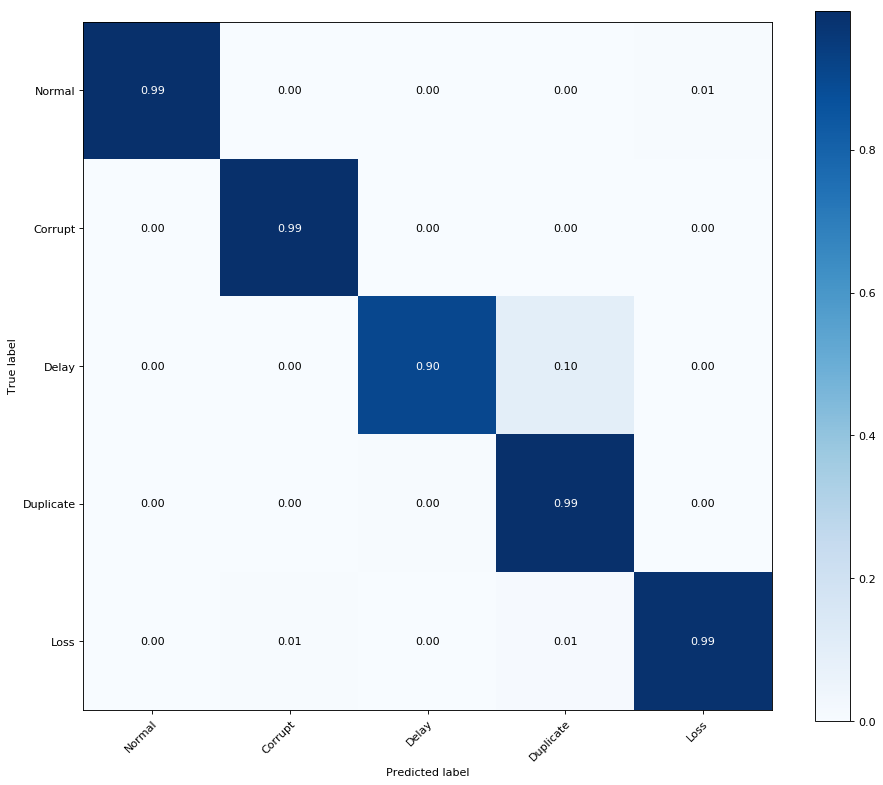

In [9]:
hpc =  DecisionTreeClassifier()
hpc.fit(hpc_train_data, hpc_train_labels)
hpc_predicted_labels = hpc.predict(hpc_test_data)
report = classification_report(hpc_test_labels, hpc_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("hpc_model_hpc_data_DT_CR.csv", sep='\t')
plot_confusion_matrix(hpc_test_labels, hpc_predicted_labels, normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('hpc_model_hpc_data_DT.pdf')
plt.show()





## RF :



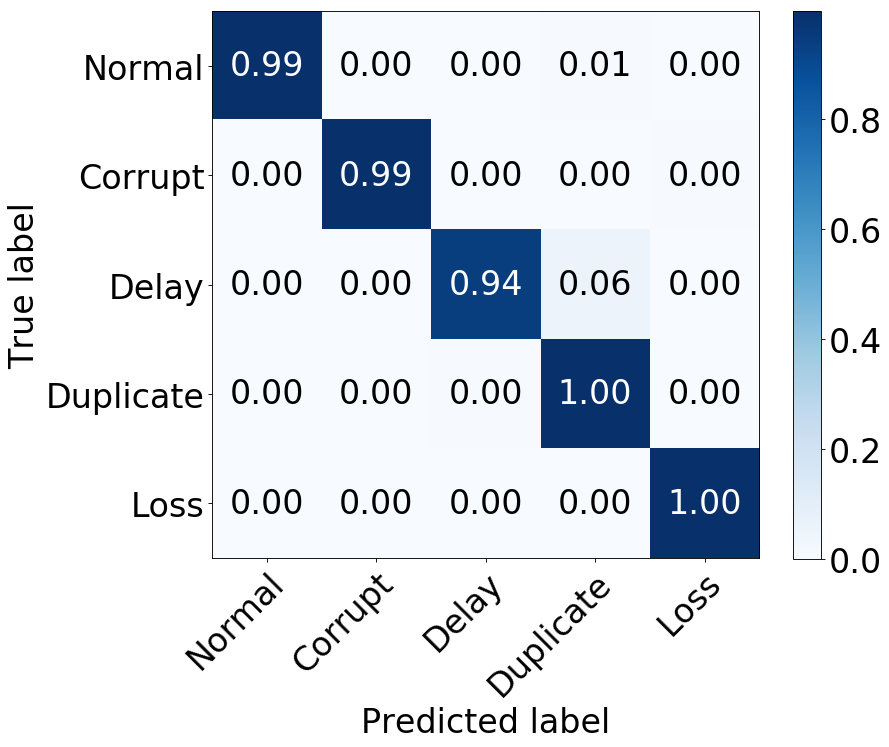

In [10]:
hpc =  RandomForestClassifier(n_estimators = 1000, random_state = 42,n_jobs = -1)
hpc.fit(hpc_train_data, hpc_train_labels)
hpc_predicted_labels = hpc.predict(hpc_test_data)
report = classification_report(hpc_test_labels, hpc_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("hpc_model_hpc_data_RF_CR.csv", sep='\t')
plot_confusion_matrix(hpc_test_labels, hpc_predicted_labels, normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('hpc_model_hpc_data_RF.pdf')
plt.show()



## SVM :

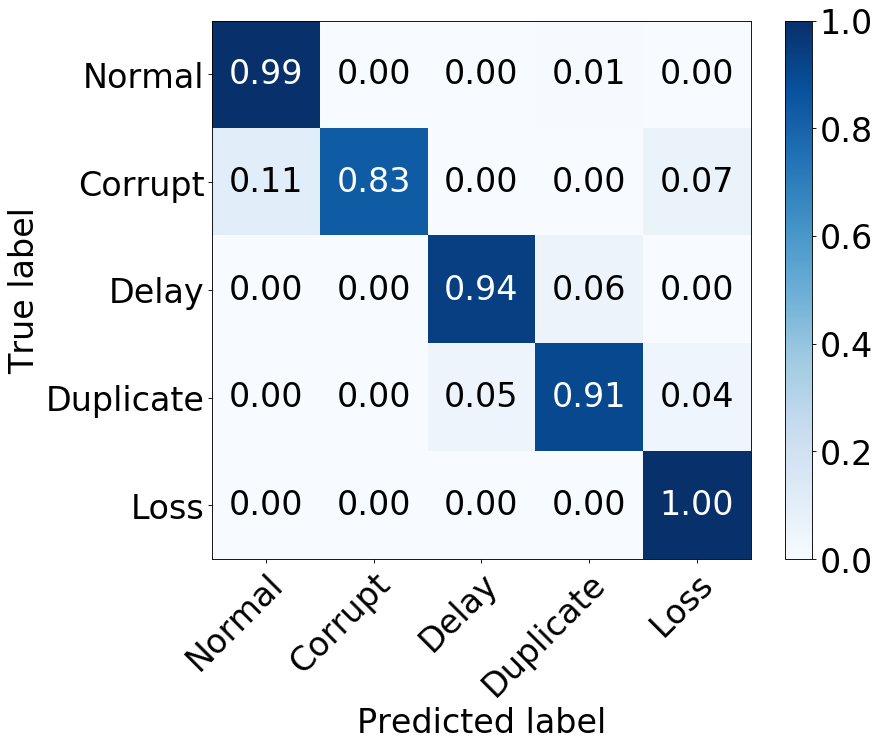

In [11]:
hpc = svm.SVC(kernel='linear', gamma ='auto', max_iter=10000)
hpc.fit(hpc_train_data, hpc_train_labels)
hpc_predicted_labels = hpc.predict(hpc_test_data)
report = classification_report(hpc_test_labels, hpc_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("hpc_model_hpc_data_SVM_CR.csv", sep='\t')
plot_confusion_matrix(hpc_test_labels, hpc_predicted_labels, normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('hpc_model_hpc_data_SVM.pdf')
plt.show()




## NN :

Train on 27388 samples, validate on 6847 samples
Epoch 1/10
27388/27388 [==============================] - 2s 85us/step - loss: 0.3234 - accuracy: 0.8761 - val_loss: 0.3354 - val_accuracy: 0.7894
Epoch 2/10
27388/27388 [==============================] - 2s 86us/step - loss: 0.1796 - accuracy: 0.9300 - val_loss: 0.2669 - val_accuracy: 0.7907
Epoch 3/10
27388/27388 [==============================] - 2s 80us/step - loss: 0.1463 - accuracy: 0.9404 - val_loss: 0.2735 - val_accuracy: 0.7982
Epoch 4/10
27388/27388 [==============================] - 2s 73us/step - loss: 0.1234 - accuracy: 0.9479 - val_loss: 0.2710 - val_accuracy: 0.7976
Epoch 5/10
27388/27388 [==============================] - 2s 74us/step - loss: 0.1106 - accuracy: 0.9536 - val_loss: 0.2722 - val_accuracy: 0.7982


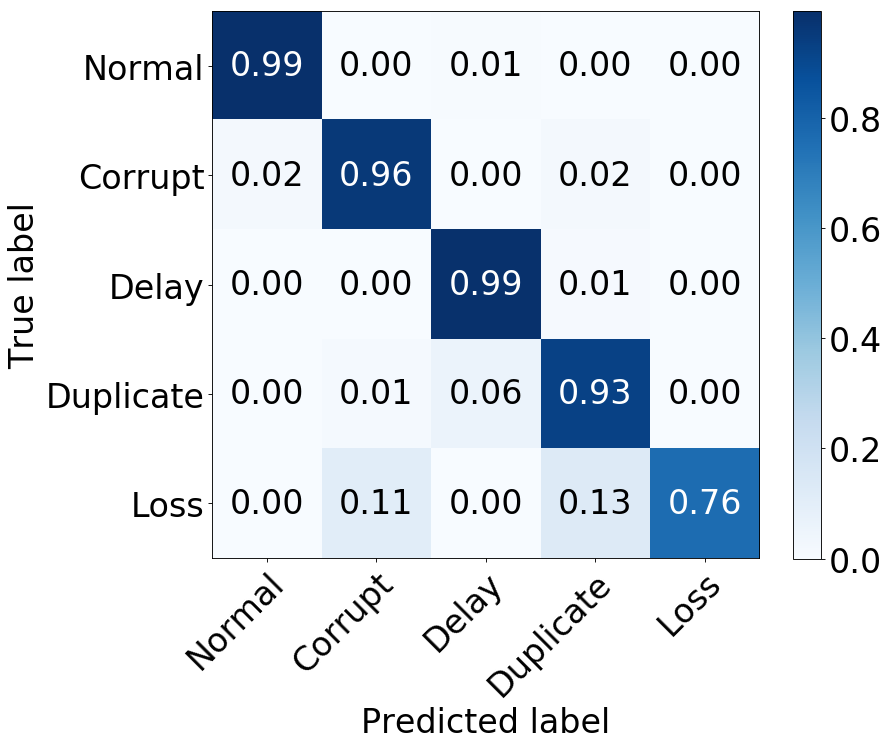

In [12]:


#create model
model = Sequential()

#get number of columns in training data
n_cols = hpc_train_data.shape[1]

#add model layers
model.add(Dense(700, activation='relu', input_dim=n_cols))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=3)

hpc_train_labels = to_categorical(hpc_train_labels)

model.fit(hpc_train_data, hpc_train_labels, validation_split=0.2, epochs=10, callbacks=[early_stopping_monitor])
hpc_predicted_labels = model.predict(hpc_test_data)
report = classification_report(hpc_test_labels,  np.argmax(hpc_predicted_labels, axis=1), output_dict=True  )
df = pd.DataFrame(report).transpose()
df.to_csv("hpc_model_hpc_data_NN_CR.csv", sep='\t')
plot_confusion_matrix(hpc_test_labels, np.argmax(hpc_predicted_labels, axis=1) , normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('hpc_model_hpc_data_NN.pdf')
plt.show()
